In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import time

tfd = tfp.distributions

In [83]:
# load mnist data - 60000 train, 10000 test
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 1

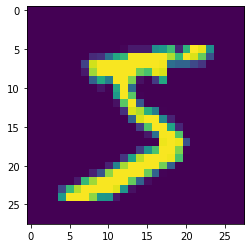

In [100]:
# normalize images between 0 and 1
f = lambda x: x / 255
train_images = f(train_images)
plt.imshow(train_images[0])
train_images[0].shape

train_images = tf.cast(train_images, tf.float32)

# create dataset, shuffle and batch them
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [101]:
class VAE(tf.keras.Model):
    """Variational autoencoder."""
    def __init__(self, latent_dim, batch_size):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.batch_size = batch_size

        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1), batch_size=batch_size))
        self.encoder.add(tf.keras.layers.Flatten())
        self.encoder.add(tf.keras.layers.Dense(256, activation='relu'))
        self.encoder.add(tf.keras.layers.Dense(256, activation='relu'))
        self.encoder.add(tf.keras.layers.Dense(latent_dim + latent_dim, activation='sigmoid'))

        self.decoder = tf.keras.Sequential()
        self.decoder.add(tf.keras.layers.InputLayer(input_shape=(latent_dim,)))
        self.decoder.add(tf.keras.layers.Dense(256, activation='relu'))
        self.decoder.add(tf.keras.layers.Dense(256, activation='relu'))
        self.decoder.add(tf.keras.layers.Dense(28*28, activation='sigmoid'))
        self.decoder.add(tf.keras.layers.Reshape((28, 28)))

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [102]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    print(x_logit.shape, x.shape)
    print(x_logit[0][0][0], x[0][0][0])
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [103]:
epochs = 10
optimizer = tf.keras.optimizers.Adam(1e-4)
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim, batch_size)

In [104]:
epochs = 30
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        print(train_x)
        train_step(model, train_x, optimizer)
        
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.0000000

ValueError: in user code:

    File "<ipython-input-70-bfacd88dd0a4>", line 27, in train_step  *
        loss = compute_loss(model, x)
    File "<ipython-input-79-697718f0f7bd>", line 13, in compute_loss  *
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

    ValueError: Invalid reduction dimension 3 for input with 3 dimensions. for '{{node Sum}} = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false](logistic_loss, Sum/reduction_indices)' with input shapes: [1,28,28], [3] and with computed input tensors: input[1] = <1 2 3>.
